# Support Vector Machine

---

Aditya Marathe

## Imports and version

In [14]:
%matplotlib inline

import sys

import numpy as np
import numpy.typing as npt

import sklearn as skl
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC


import tensorflow as tf
from tensorflow import keras

import matplotlib as mpl
import matplotlib.pyplot as plt

**Local**:

In [2]:
sys.path.insert(1, './../')

import ana
from utils import *
from transforms import *

In [3]:
ana.init_global_plotting_style()

**Version**:

In [4]:
print(f'Python {sys.version}\n')
print(f'NumPy {np.__version__}')
print(f'Matplotlib {mpl.__version__}')
print(f'Tensorflow {tf.__version__}')
print(f'SciKitLearn {skl.__version__}')

Python 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]

NumPy 1.26.1
Matplotlib 3.8.1
Tensorflow 2.10.1
SciKitLearn 1.3.2


## Loading the data

In [5]:
ds = Datasets()

Datasets found:
- MINI_DATA_DIR
- DATA_V2_DIR
- DATA_V3_DIR
- REALLY_MINI_DIR
- COPYMERGED_C6_DIR
- COPYMERGED_C7_DIR
- COPYMERGED_C8_DIR
- COPYMERGED_C9_DIR
- COPYMERGED_C10_DIR


In [6]:
data = ana.NOvAData.init_from_copymerge_h5(
    h5dirs=[
        # ds.COPYMERGED_C8_DIR,  # type: ignore
        # ds.COPYMERGED_C9_DIR,  # type: ignore
        ds.COPYMERGED_C10_DIR  # type: ignore
    ]
)

In [7]:
data.table.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 184661 entries, (15021, 10, 0, 0, 1, 1) to (15112, 63, 0, 0, 1000, 2)
Data columns (total 55 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   rec.energy.numu.E                   184661 non-null  float32
 1   rec.energy.numu.calccE              184661 non-null  float32
 2   rec.energy.numu.hadcalE             184661 non-null  float32
 3   rec.energy.numu.hadtrkE             184661 non-null  float32
 4   rec.energy.numu.lstmmuon            184661 non-null  float32
 5   rec.energy.numu.lstmnu              184661 non-null  float32
 6   rec.energy.numu.regcvnhadE          184661 non-null  float32
 7   rec.energy.numu.trkccE              184661 non-null  float32
 8   rec.energy.numu.recomuonE           184661 non-null  float32
 9   rec.energy.numu.hadclust.calE       184661 non-null  float32
 10  rec.energy.numu.hadclust.nhit       184661 non-nul

In [8]:
data.fill_ana_flags(inplace=True)
data.fill_ana_track_kinematics(inplace=True)

## Data prep.

In [9]:
useful_vars = [
	'rec.energy.numu.calccE',
	'rec.energy.numu.hadcalE',
	'rec.energy.numu.hadtrkE',
	'rec.energy.numu.lstmmuon',
	'rec.energy.numu.regcvnhadE',
	'rec.energy.numu.trkccE',
	'rec.energy.numu.recomuonE',
	'rec.energy.numu.hadclust.calE',
	'rec.energy.numu.hadclust.nhit',
	'rec.sel.contain.kalfwdcell',
	'rec.sel.contain.kalbakcell',
	'rec.sel.contain.cosfwdcell',
	'rec.sel.contain.cosbakcell',
	'rec.sel.cosrej.numucontpid2020fhc',
	'rec.sel.cvnloosepreselptp.cosmicid',
	'rec.sel.cvnloosepreselptp.ncid',
	'rec.sel.cvnloosepreselptp.nueid',
	'rec.sel.cvnloosepreselptp.numuid',
	'rec.sel.cvnloosepreselptp.nutauid',
	'rec.sel.remid.pid',
	'rec.sel.scann.scpid',
	'rec.slc.calE',
	'rec.slc.firstplane',
	'rec.slc.lastplane',
	'rec.slc.nhit',
	'rec.slc.ncontplanes',
	'rec.trk.cosmic.ntracks',
	'rec.trk.kalman.ntracks',
	'rec.trk.kalman.ntracks2d',
	'ana.trk.kalman.tracks.cosBeam', 
	'ana.trk.kalman.tracks.PtToPmu',
	'ana.trk.kalman.tracks.Pmu', 
	'ana.trk.kalman.tracks.Pt',
	'ana.mc.flag.isNuMuCC'
]

scale_vars = [
	'rec.energy.numu.calccE',
	'rec.energy.numu.hadcalE',
	'rec.energy.numu.hadtrkE',
	'rec.energy.numu.lstmmuon',
	'rec.energy.numu.regcvnhadE',
	'rec.energy.numu.trkccE',
	'rec.energy.numu.recomuonE',
	'rec.energy.numu.hadclust.calE',
	'rec.energy.numu.hadclust.nhit',
	'rec.sel.contain.kalfwdcell',
	'rec.sel.contain.kalbakcell',
	'rec.sel.contain.cosfwdcell',
	'rec.sel.contain.cosbakcell',
	'rec.slc.calE',
	'rec.slc.firstplane',
	'rec.slc.lastplane',
	'rec.slc.nhit',
	'rec.slc.ncontplanes',
	'rec.trk.cosmic.ntracks',
	'rec.trk.kalman.ntracks',
	'rec.trk.kalman.ntracks2d',
	'ana.trk.kalman.tracks.cosBeam', 
	'ana.trk.kalman.tracks.PtToPmu',
	'ana.trk.kalman.tracks.Pmu', 
	'ana.trk.kalman.tracks.Pt'
]

In [10]:
table = data.table.reset_index(drop=True)

In [11]:
cuts = ana.Cuts.init_nova_cuts()

In [12]:
# Cuts
table = cuts.apply_cut('Detector Quality', table)
table = cuts.apply_cut('Data Quality', table)
table = cuts.apply_cut('Cosmic Rej.', table)
table = cuts.apply_cut('Veto', table)
# table = cuts.apply_cut('CVN PID Score', table)
# table = cuts.apply_cut('Containment', table)

In [13]:
# Transforms
table = tf_290124_positive_energies(table)
table = tf_290124_valid_pid(table)
table = tf_120224_first_prong(table)

In [15]:
# Training data and labels
x_table = table[useful_vars]
y_table = x_table.pop('ana.mc.flag.isNuMuCC')

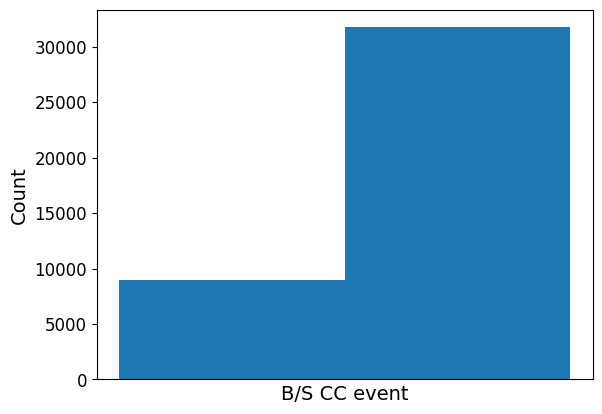

In [17]:
plt.hist(
    y_table.values,
    bins=np.linspace(0, 1, 2 + 1)  # type: ignore
)
plt.ylabel('Count')
plt.xlabel('B/S CC event')
plt.xticks([]);

In [22]:
y_table

3         1.0
5         1.0
21        0.0
26        1.0
29        1.0
         ... 
184647    1.0
184650    1.0
184653    1.0
184656    1.0
184659    1.0
Name: ana.mc.flag.isNuMuCC, Length: 40734, dtype: float64

In [23]:
x_train_table, x_test_table, y_train_table, y_test_table = train_test_split(
    x_table, y_table, test_size=0.2, random_state=42
)

## Model

In [24]:
svm_model = SVC(kernel='linear')
svm_model.fit(x_train_table, y_train_table)

In [ ]:
prediction = svm_model.predict(x_test_table)